In [1]:
from pickle import dump

import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import config

data = pd.read_csv(config.output_csv)

In [10]:
# model 1

X = data[['h_px']].values.reshape(-1, 1)
Y = data['cm'].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42)

reg = LinearRegression().fit(X, Y)

print(f'     r2: {reg.score(x_test, y_test)}')
print(f'      m: {reg.coef_[0]}')
print(f'      b: {reg.intercept_}')

ttest_1samp(np.abs(reg.predict(x_test) - y_test), 1)

     r2: 0.9803312828768752
      m: [0.06848338]
      b: [-1.64575411]


Ttest_1sampResult(statistic=array([-9.56433052]), pvalue=array([1.79533381e-10]))

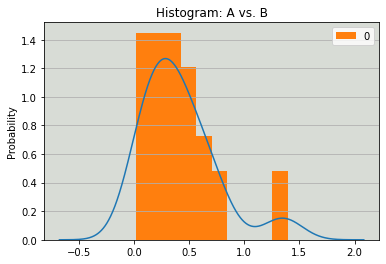

In [11]:
import matplotlib.pyplot as plt

d = pd.DataFrame(np.abs(reg.predict(X) - Y))

fig, ax = plt.subplots()
d.plot.kde(ax=ax, legend=False, title='Histogram: A vs. B')
d.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

In [3]:
# model 2

X = data[['h_px', 'w_px']].values.reshape(-1, 2)
Y = data['cm'].values.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42)

reg = LinearRegression().fit(x_train, y_train)

print(f'     r2: {reg.score(x_test, y_test)}')
print(f'      m: {reg.coef_[0]}')
print(f'      b: {reg.intercept_}')

ttest_1samp(np.abs(reg.predict(X) - Y), 1)

     r2: 0.9626958076021519
      m: [0.06247558 0.01922698]
      b: [-2.36993031]


Ttest_1sampResult(statistic=array([-8.3141958]), pvalue=array([3.6414767e-09]))

In [4]:
# model 3

X = data[['h_px', 'w_px']].values.reshape(-1, 2) ** 2
Y = data['cm'].values.reshape(-1, 1) ** 2

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42)

reg = LinearRegression().fit(x_train, y_train)

print(f'     r2: {reg.score(x_test, y_test)}')
print(f'      m: {reg.coef_[0]}')
print(f'      b: {reg.intercept_}')

ttest_1samp(np.abs(np.sqrt(reg.predict(X)) - np.sqrt(Y)), 1)

     r2: 0.9677194649848938
      m: [0.00410402 0.00239091]
      b: [-56.21928622]


Ttest_1sampResult(statistic=array([-8.95296173]), pvalue=array([7.62472452e-10]))